In [176]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import jqdatasdk as jq
import os

# 请在环境变量中设置聚宽账号。账号可在jointquant.com上免费申请
account = os.environ.get('JQ_ACCOUNT')
password = os.environ.get('JQ_PASSWORD')

上一篇里我们已经检视了市面上常用的行情数据包，并且以jqdatasdk为例，尝试获取了上证指数5天的数据。在这一章里，我们将深入探讨jqdatasdk提供的API能力，并且我们应该如何组合这些API来完成一些简单的策略。如果你看到文章最后，会发现也许这些简单的策略就已经相当有用了，因为你在网络上看到的一些大V，他们也在用类似的方法选股。

在跟随本文进行学习时，建议你先安装好jupyter notebook，本文正是由notebook生成的，这个源文件也可以在https://github.com/zillionare/AI-trading-tutorial 上下载。通过jupyter notebook，你将随时可以运行本文中的示例代码。

# API
首先，我们需要有获取全市场标的列表的能力，如此以来，我们便能以此为起点，进一步获取全市场标的的行情数据。在jq中，API是这样的：

In [189]:
securites = jq.get_all_securities(types=['stock'], date=None)
securites[:5]

,display_name,name,start_date,end_date,type
000001.XSHE,平安银行,PAYX,1991-04-03,2200-01-01,stock
000002.XSHE,万科A,WKA,1991-01-29,2200-01-01,stock
000004.XSHE,国农科技,GNKJ,1990-12-01,2200-01-01,stock
000005.XSHE,世纪星源,SJXY,1990-12-10,2200-01-01,stock
000006.XSHE,深振业A,SZYA,1992-04-27,2200-01-01,stock


返回值包括证券代码（如000001.XSHG）,证券名称（如平安银行，上证指数等），证券简码(如PAYX)，该证券的上市交易日，终止上市时间，以及证券类型。

最后一栏是证券类型。jq支持的证券类型主要有股票(stock)，指数(index),ETF基金(etf),此外还有分级(fja,fjb,fjm），场内交易货币基金和其它基金等。可转债作为惟一的一个可以T+0操作的标的种类，jq目前还不支持，这也是一个遗憾。

这里提示一下关于上市交易日和终止上市时间的使用。在做短线交易时，我们并不需要获取那些已退市证券的数据，这时就要使用终止上市时间来进行过滤。有时候为了获取足够长的数据来进行演算，我们也需要使用上市交易日来过滤掉一些刚上市不久、数据还不够充分的数据。

证券代码在不同的行情软件中，表示方法并不一致。上交所和深交所原始数据中，并没有上述代码中的".XSHG"这样的后缀，因此，000001在不同的市场上可能都存在，只是定义不同。比如000001在上交所这边代表上证指数，而在深交所则代表平安银行。如果你拿到的是这样的数据，则需要先进行转码处理。在JQ的数据中，后缀是证券交易所的代码。这样处理是比较恰当的。每个证交所都会保证自己的编码系统的惟一性。

接下来，我们需要获取证券交易日历。多数行情API在获取数据时，都是使用相对于某个时间的"bars"数来指定返回结果的记录条数。如果你想使用去年1月1日到今年1月1日之间的数据，那么你必须自己计算在这个期间，共有多少条记录。要计算这个条数，首先必须有交易日历。

In [6]:
all_best_days = jq.get_all_trade_days()
all_best_days[:5]

array([datetime.date(2005, 1, 4), datetime.date(2005, 1, 5),
       datetime.date(2005, 1, 6), datetime.date(2005, 1, 7),
       datetime.date(2005, 1, 10)], dtype=object)

Aha! jq提供的交易数据都是起始于2005年1月4日的。因此，如果你要追忆老八股当年的盛况，还得使用其它数据源。不过，对我们短线量化而言，这个数据已足够充分了。实际上，过久的历史数据如果不能正确使用，反倒会让你得出错误结论。比如，一些股票退市了，会导致幸存者偏差（幸运的是，为了不让你们出这种错误，村里很少让股票退市！）；这期间发生的重大的制度改革（比如股权分置改革就是从2005年起的），则会对某些分析方法产生影响。当然，对于短线而言，我们只关心股价，我们认为一切因素都反映在股价里。所以只要股本变动、除权除息这些事都已正确记录的话，几乎仅凭行情数据本身，我们仍然可以分析出正确结论。

对于前面的问题，要获取去年1月1日到今年1月1日之间的数据，比如上证指，我们可以这样操作

In [13]:
days = jq.get_trade_days('2019-1-1', '2020-1-1')
print(f"起始时间:{days[0]}, 结束时间{days[-1]}, 总共{len(days)}个交易日")
bars = jq.get_bars('000001.XSHG', len(days), unit='1d', end_dt='2020-1-1')
print(bars[:3])
print(bars[-3:])

起始时间:2019-01-02, 结束时间2019-12-31, 总共244个交易日
         date     open     high      low    close
0  2019-01-02  2497.88  2500.28  2456.42  2465.29
1  2019-01-03  2461.78  2488.48  2455.93  2464.36
2  2019-01-04  2446.02  2515.32  2440.91  2514.87
           date     open     high      low    close
241  2019-12-27  3006.85  3036.11  3003.63  3005.04
242  2019-12-30  2998.17  3041.40  2983.34  3040.02
243  2019-12-31  3036.39  3051.68  3030.51  3050.12


一般我们按250天算年线，不过对于2019年来讲，这一年只有244个交易日。尽管指定的时间范围是2019年1月1日到2020年1月1日，但我们获得的上证指数，从2019年1月2日起，到2019年12月31日止。因为交易日历告诉我们，2019年的第一个交易日，是1月2日。

这里引出了我们在上一篇文章中已经见到的一个API，get_bars，其定义如下：

In [ ]:
get_bars(security, count, unit='1d',
      fields=['date','open','high','low','close'],
         include_now=False, end_dt=None, fq_ref_date=None,df=True)

一般情况下，建议改写fields。fields接受的完整列表包括： 'date', 'open','high','low','close','volume','money','open_intereset','factor'。返回结果中，volume为成交量，以手数（100股为一手）为单位，money为成交额。

默认情况下，这个API返回的数据是不复权的，如果要返回复权数据，则需要通过fq_ref_date来指定复权日期，这样返回的数据，都会复权到指定日期那一天为止。如果你需要将数据缓存起来，建议始终取未复权的数据，然后在使用数据时，通过复权因子来计算。如果你将未复权数据与复权数据混用在一起，可想而知，最终结果会是错的。在不同时间，分段取得的复权数据，也是不能混用的。比如，你已经有了截止上一周的某个股票的复权数据，现在只取本周的增量数据，但指定复权到当天，这样两组数据也是不能混用的。

这个API返回的数据格式有两种，一种是pandas的DataFrame,另一种是numpy的structured array。推荐使用structured array，因为这种数据结构无论是计算效率，还是内存效率都要远高于DataFrame(接近一倍左右）。另外，我更喜欢numpy的structured array的index方式，比如：

In [ ]:
# 对numpy structured array结构，以下引用是合法的
bars[-1]['close']
# 或者
bars['close'][-1]
# 对Dataframe结构，你应该始终使用这样的方式来引用最后一天的收盘价
bars['close'].iat[-1]
# 显然，numpy的方式更简洁

JQ的这个API有一些难以理解的地方，主要体现在include_now这个参数上。如果现在的时间是2020年10月13日下午16时，由于A股已经收盘，因此当天的上证指数已经锁定。但你这样调用get_bars，却得不到这一天的数据，这是我们需要加以小心的地方：

In [40]:
# 这样只会返回到10-12的数据
bars = jq.get_bars('000001.XSHG', 1, unit='1d',end_dt='2020-10-13')
print(bars)

# 这样也只返回到10-12的数据
bars = jq.get_bars('000001.XSHG', 1, unit='1d',end_dt='2020-10-13',include_now=True)
print(bars)

# 这样则会返回到10-13的数据，但如果是盘中调用，则是调用当时的数据，当然，似乎也只能这样
bars = jq.get_bars('000001.XSHG', 1, unit='1d',end_dt=None, include_now=True)
print(bars)

# 如果在盘后这样调用，也能返回10-13日的数据，但在盘中这样调用，返回的数据却是调用当时的数据
bars = jq.get_bars('000001.XSHG', 1, unit='1d',end_dt='2020-10-13 16:00:00', include_now=True)
print(bars)

         date     open     high      low    close
0  2020-10-12  3287.33  3359.15  3286.11  3358.47
         date     open     high      low    close
0  2020-10-12  3287.33  3359.15  3286.11  3358.47
         date       open       high        low      close
0  2020-10-13  3353.1213  3361.8315  3334.4989  3359.7499
         date       open       high        low      close
0  2020-10-13  3353.1213  3361.8315  3334.4989  3359.7499
         date       open       high        low      close
0  2020-10-13  3353.1213  3361.8315  3334.4989  3359.7499


现在，让我们用get_bars来做一点实际的工作。我们来画一条平吉林森工今天（2020年10月13日）的分时线。
注意分时线的均线有两种算法。我们对个股是用截止当前的成交额（使用numpy的cumsum函数），除以截止当前的成交量来求得的。它对波动起到有效地平滑作用，而且成交量越小的价格，在最终均价中占的权重也越小，从而滤掉了做骗线的杂波。对于指数，上述方法似乎不对，可能跟指数编制方法有关，所以这里使用的是截止当前时刻的指数平均。

In [79]:
fields = ['date', 'open','high','low','close', 'volume', 'money']
bars = jq.get_bars('600189.XSHG', 240, '1m', end_dt='2020-10-13 15:00:00', fields=fields,df=False)
bars_sh = jq.get_bars('000001.XSHG', 240, '1m', end_dt='2020-10-13 15:00:00', fields=fields,df=False)

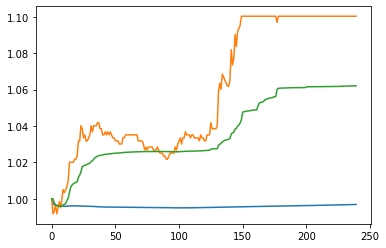

In [93]:
# 大盘走势,为便于比较，使用了涨跌幅
plt.plot((np.cumsum(bars_sh['close'])/np.cumsum(bars_sh['close']>0))/bars_sh['close'][0])
# 吉林森工的股价变化
plt.plot(bars['close']/bars['close'][0])
# 吉林森工的均价线
plt.plot((np.cumsum(bars['money'])/np.cumsum(bars['volume']))/bars['close'][0])

上图中，黄色的线是个股的收盘分时线，绿色线是其均价线，蓝色线是大盘均价线。从图中可以看出，一开盘在大盘下探时，吉林森工股价就快速上涨，此后随大盘微跌，但均价线支撑有力。在午后确认大盘企稳后，主力快速拉升到涨停。这就是教程的第一个策略：通过分时线与大盘走势对比，来确定个股的强弱。是否有效，还请大家验证。

下面，我们快速过一些其它跟行情数据相关API。

- get_price(security, start_date=None, end_date=None, frequency='daily')
这个API的作用与get_bars类似，但允许传入开始和结束时间。在最新的版本里，这个函数的功能似乎比get_bars要强一些，比如可以取到涨停价和跌停价。
- get_call_auction 取集合竞价数据
获得的集合竞价是早间的集合竞价值，最晚于09:28分前返回。

下面介绍jq的非行情相关API。

每支证券（股票）都有自己的行业属性、地域属性（总部或者注册地），此外还有概念（题材）属性。除此之外，象通达信软件，还会给每支股票打上风格属性，比如"新股"、"近期强势"、"超跌"等。在A股，市场炒作气氛浓郁时，会发生炒地图（比如最近的深圳本地股，前段时间的海南自贸）、炒概念（前段时间的免税、地摊）、炒行业（近期的光伏既是概念、也是行业。光伏景气是一个行业全产业链的景气）。对短线炒题材的选手来说，如何蹭到具有多个概念的股票，是很重要的选股策略。

这里我们以如何找出同时具有多个概念的个股为例，来讲解jq相关的API。

假设我们要获取具有"智能电网"、"物联网”概念属性的深圳本地股：

In [182]:
# 获取地域。这里要使用finance中的查询
from jqdatasdk import finance
from jqdatasdk import query
code = '000001.XSHE'
rec = finance.run_query(query(finance.STK_COMPANY_INFO).filter(finance.STK_COMPANY_INFO.code==code).limit(1))
print(rec['province'][0],rec['city'][0])

广东 深圳市


In [198]:
#我们使用下面的函数，将前面获得的securities对象加上两列，即province和city
def add_region_info(securities):
    company_infos = finance.run_query(query(finance.STK_COMPANY_INFO))
    for code in securites.index:
        rec = company_infos[company_infos['code'] == code]
        if len(rec) == 0:
            securities.loc[code, 'province'] = None
            securities.loc[code, 'city'] = None
        else:
            securities.loc[code, 'province'] = rec['province'].iat[0]
            securities.loc[code, 'city'] = rec['city'].iat[0]
add_region_info(securites)

In [ ]:
# 获取概念板块
concepts = jq.get_concepts()

def query_stock_by_concept(query_concepts, province=None, city=None):
    stocks = set()
    for name in query_concepts:
        concept = concepts[concepts['name'] == name]
        if len(concept) == 0:
            continue
            
        idx = concept.index[0]
        members = set(jq.get_concept_stocks(idx))
        if len(stocks) == 0:
            stocks = members
        else:
            stocks = stocks.intersection(members)
         
    results = []

    for code in stocks:
        if province and securites.loc[code, 'province'] != province:
            continue
        if city and securites.loc[code, 'city'] != city:
            continue
            
        results.append(code)
        
    return results
        
#jq.get_concept_stocks('GN001')
stocks = query_stock_by_concept(['智能电网','物联网'],'广东','深圳市')
print(stocks)

**声明：本教程中引用到的股票代码，仅为演示如何使用相关API之目的，并非推荐。**

好了！受相关限制，一些知名的大V是不会在头条或者微博里晒他们选的股的，但会提示相关概念。现在，你是不是能跟上他们的步子了呢？